In [75]:
import os
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Preprocessing and Visualization**

In [52]:
# load the dataset

dataset = pd.read_csv("/content/Suicide_Ideation_Dataset(Twitter-based).csv")


In [53]:
# drop missing values

dataset.dropna(inplace = True)


In [54]:
# rename labels and columns

dataset = dataset.rename(columns = {'Suicide': 'Label'})

dataset['Label'] = ['Normal' if label == 'Not Suicide post' else 'Suicidal' for label in dataset['Label']]


In [55]:
# display the dataset

dataset.head()

,Tweet,Label
0,making some lunch,Normal
1,@Alexia You want his money.,Normal
2,@dizzyhrvy that crap took me forever to put to...,Suicidal
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Normal
4,Trying out &quot;Delicious Library 2&quot; wit...,Normal


In [76]:
dataset.shape

(1785, 2)

In [56]:
def cleaner(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    return text

dataset['Tweet'] = dataset['Tweet'].apply(cleaner)

**Exploratory Visualizations**

Label Distribution

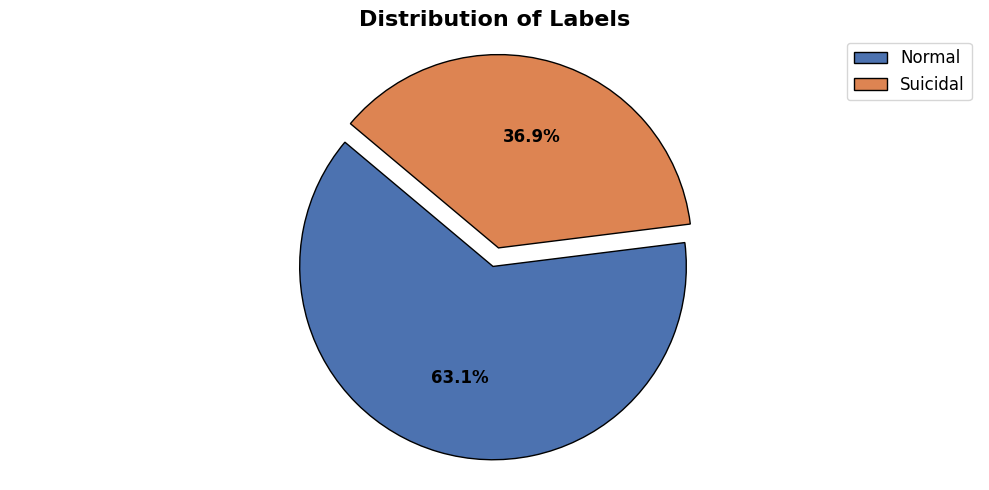

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))

labels = dataset['Label'].value_counts().index
sizes = dataset['Label'].value_counts().values
colors = sns.color_palette('deep')

wedges, texts, autotexts = ax.pie(sizes, colors = colors,
                                  autopct = '%1.1f%%', startangle = 140,
                                  explode = (0.1, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels', fontsize = 16, fontweight = 'bold')
ax.axis('equal')
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

Word cloud

In [61]:
normal_text_data = dataset[dataset['Label'] == 'Normal']['Tweet'].values
suicide_text_data = dataset[dataset['Label'] == 'Suicidal']['Tweet'].values

all_normal_text = ' '.join(normal_text_data)
all_suicide_text = ' '.join(suicide_text_data)

wordcloud_normal = WordCloud(width = 400, height = 400,
                             background_color = 'white').generate(all_normal_text)
wordcloud_suicide = WordCloud(width = 400, height = 400,
                              background_color = 'white').generate(all_suicide_text)

plt.figure(figsize = (15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

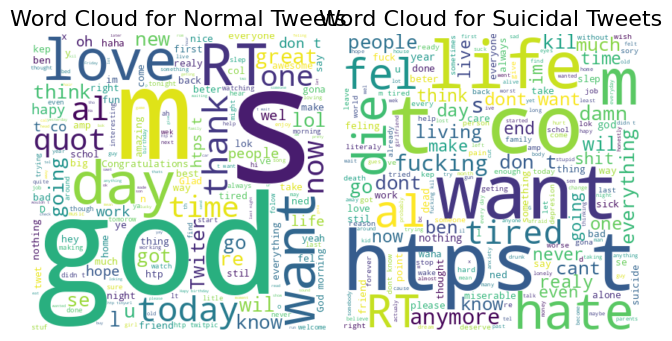

In [62]:
# normal tweets

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_normal, interpolation = 'bilinear')
plt.title('Word Cloud for Normal Tweets', fontsize = 16)
plt.axis('off')

# suicidal tweets

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_suicide, interpolation = 'bilinear')
plt.title('Word Cloud for Suicidal Tweets', fontsize = 16)
plt.axis('off')

plt.tight_layout()
plt.show()

**Data Preprocessing**

*In this section, we'll preprocess our data to prepare it for model training*

In [63]:
# create tokenizer

def preprocessor(text):
    text = word_tokenize(text.lower())
    text = [PorterStemmer().stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

# initialize labelEncoder & countVectorizer

encoder = LabelEncoder()
vectorizer = CountVectorizer()

In [64]:
!pip install nltk

In [65]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
# clean all the emails
dataset['Tweet'] = dataset['Tweet'].apply(preprocessor)
#encode the labels
dataset['Label'] = encoder.fit_transform(dataset['Label'])
# display the modified dataset
dataset.head()

,Tweet,Label
0,make lunch,0
1,alexia want money,0
2,dizyhrvi crap tok forev put togeth go go slep day,1
3,jnaylor kiwitwet hey jer sinc start twiter,0
4,tri quot delici librari quot mix result bar co...,0


In [67]:
# extract features and target

X = vectorizer.fit_transform(dataset['Tweet']).toarray()
y = dataset.iloc[:, -1].values

# split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [68]:
# print the shape of train/test features and labels

print(f'\nShape of Training Features (X_train) --> {X_train.shape} and \
Training Labels (y_train) --> {y_train.shape}')

print(f'\nShape of Testing Features (X_train) --> {X_test.shape} and \
Testing Labels (y_test) --> {y_test.shape}')


Shape of Training Features (X_train) --> (1428, 5149) and Training Labels (y_train) --> (1428,)

Shape of Testing Features (X_train) --> (357, 5149) and Testing Labels (y_test) --> (357,)


**Developing the Classification Model**

In [69]:
# initialize the classifier

model = XGBClassifier()

# train the model

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
# predict the labels

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

**Evaluating the Classifier**

*we'll assess the performance of our suicide tweet classification model*

In [71]:
# display the accuracy

print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 97.48 %
Test Accuracy : 96.08 %


In [72]:
# display classification report

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print('-----------------------------------------------------')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       907
           1       0.98      0.95      0.96       521

    accuracy                           0.97      1428
   macro avg       0.98      0.97      0.97      1428
weighted avg       0.97      0.97      0.97      1428

-----------------------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       219
           1       0.96      0.94      0.95       138

    accuracy                           0.96       357
   macro avg       0.96      0.96      0.96       357
weighted avg       0.96      0.96      0.96       357



Evaluation Visualization

*Here, we'll visualize the evaluation metrics to gain insights into our classifier's performance*

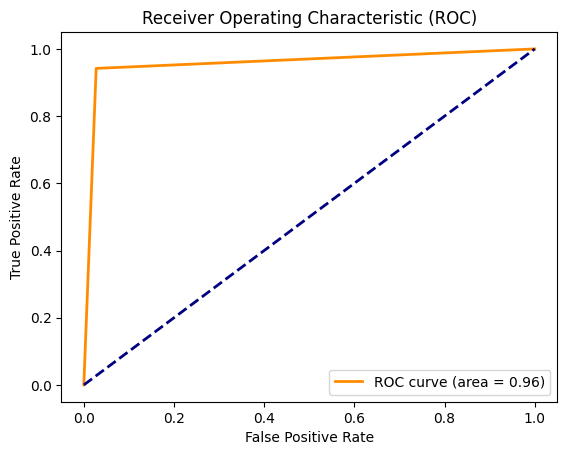

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.show()

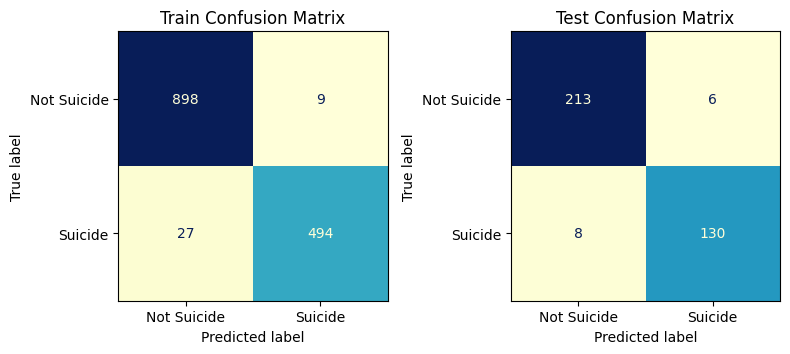

In [74]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['Not Suicide', 'Suicide']

disp_train = ConfusionMatrixDisplay(confusion_matrix = train_matrix, display_labels = class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

# train

disp_train.plot(ax=axs[0], cmap = 'YlGnBu', colorbar = False)
axs[0].set_title('Train Confusion Matrix')

# test

disp_test.plot(ax=axs[1], cmap = 'YlGnBu', colorbar = False)
axs[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()
